In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

2023-12-22 20:06:04.285867: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 20:06:04.285899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 20:06:04.286832: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-22 20:06:04.292728: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-22 20:06:05.177073: W tensorflow/compiler/tf2

In [2]:
dataframe = pd.read_csv('../scripting/ecg_downloader/data/merged_ecg_data.csv')
transposed_dataframe = dataframe.transpose()
raw_data = transposed_dataframe.values
transposed_dataframe.head

<bound method NDFrame.head of      0         1         2         3         4         5         6        \
ECG  0.89936  0.830238  0.780865  0.751242  0.741367  0.701869  0.672245   

     7         8         9        ...   1499990   1499991   1499992   1499993  \
ECG  0.68212  0.662371  0.642621  ...  0.010649  0.010649  0.010649  0.010649   

      1499994   1499995   1499996   1499997   1499998   1499999  
ECG  0.010649  0.010649  0.020523  0.050147  0.060022  0.079771  

[1 rows x 1500000 columns]>

In [3]:
subjects_reshaped = transposed_dataframe.values.reshape((250, 6000))
subjects_reshaped.shape

(250, 6000)

In [4]:
first_100_points = subjects_reshaped[:, :100]
#first_100_points = subjects_reshaped
first_100_points.shape

(250, 100)

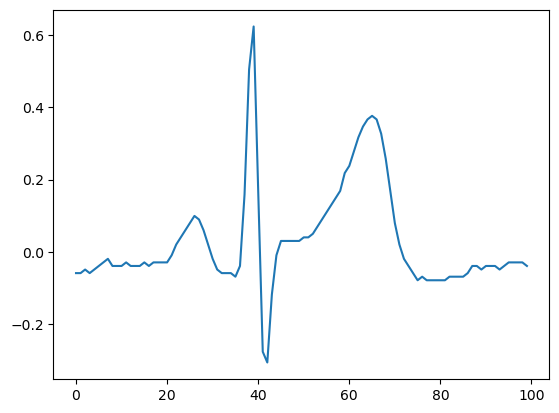

In [5]:
plt.plot(first_100_points[14])

In [6]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(100, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

2023-12-22 20:06:06.767531: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-12-22 20:06:06.767572: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: 033b258647f7
2023-12-22 20:06:06.767578: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: 033b258647f7
2023-12-22 20:06:06.767679: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 515.105.1
2023-12-22 20:06:06.767700: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.223.2
2023-12-22 20:06:06.767706: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 470.223.2 does not match DSO version 515.105.1 -- cannot find working devices in this configuration


In [7]:
autoencoder.compile(optimizer='adam', loss='mae')

In [46]:
history = autoencoder.fit(first_100_points, first_100_points, 
          epochs=2000, 
          batch_size=256,
          shuffle=True)

Epoch 1/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.1699
Epoch 2/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.1699
Epoch 3/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.1700
Epoch 4/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.1699
Epoch 5/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.1699
Epoch 6/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.1698
Epoch 7/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.1698
Epoch 8/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.1699
Epoch 9/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.1699
Epoch 10/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.1699
Epoch 11/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.1699
Epoch 12/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.1698
Epoch 13/2000
1/1 [==============================

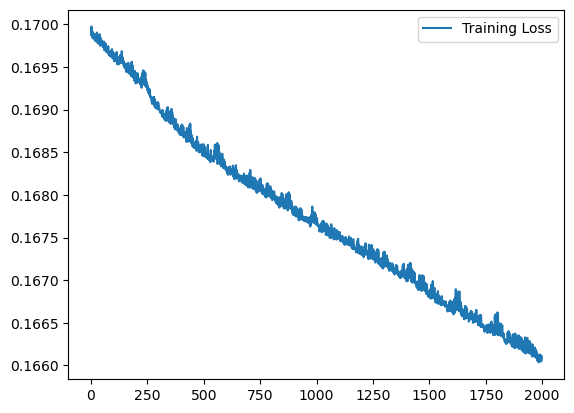

In [47]:
plt.plot(history.history["loss"], label="Training Loss")
plt.legend()

In [48]:
encoded_data = autoencoder.encoder(first_100_points).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

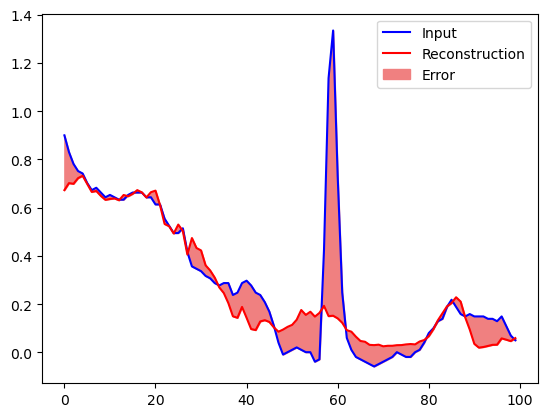

In [49]:
plt.plot(first_100_points[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(100), decoded_data[0], first_100_points[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

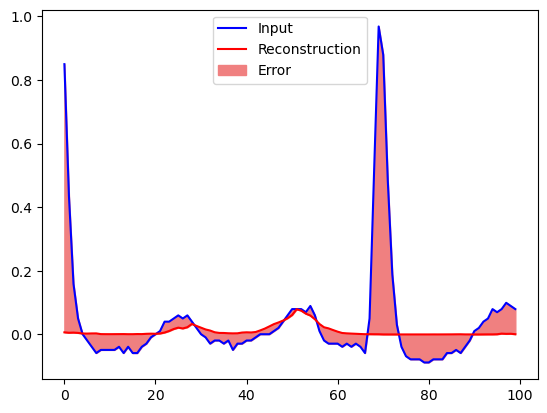

In [50]:
plt.plot(first_100_points[1], 'b')
plt.plot(decoded_data[1], 'r')
plt.fill_between(np.arange(100), decoded_data[1], first_100_points[1], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

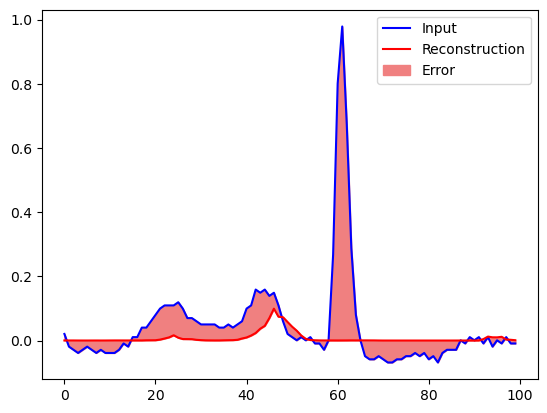

In [51]:
plt.plot(first_100_points[2], 'b')
plt.plot(decoded_data[2], 'r')
plt.fill_between(np.arange(100), decoded_data[2], first_100_points[2], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

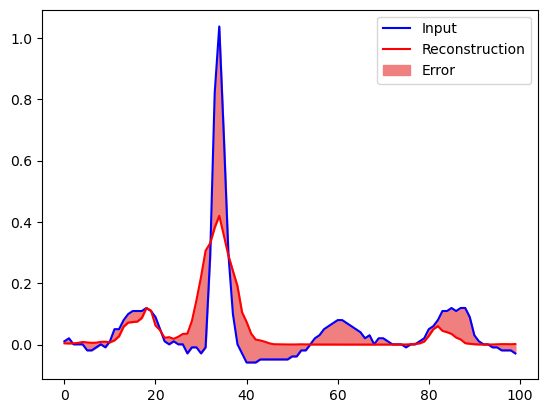

In [52]:
plt.plot(first_100_points[3], 'b')
plt.plot(decoded_data[3], 'r')
plt.fill_between(np.arange(100), decoded_data[3], first_100_points[3], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

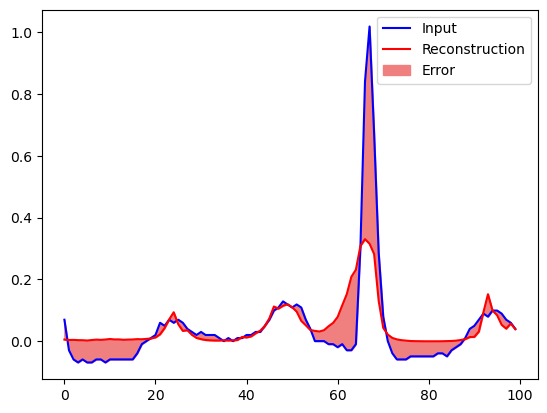

In [53]:
plt.plot(first_100_points[4], 'b')
plt.plot(decoded_data[4], 'r')
plt.fill_between(np.arange(100), decoded_data[4], first_100_points[4], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

8/8 [==============================] - 0s 1ms/step


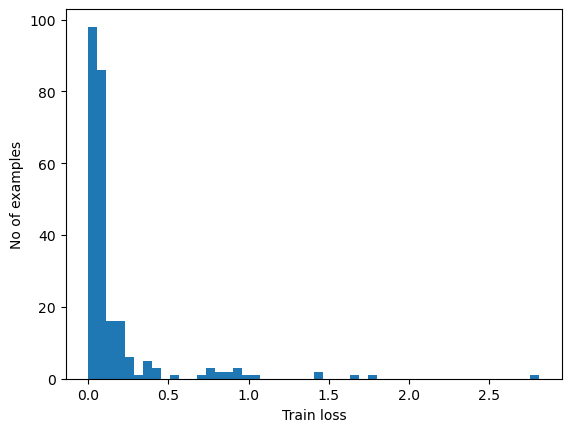

In [54]:
reconstructions = autoencoder.predict(first_100_points)
train_loss = tf.keras.losses.mae(reconstructions, first_100_points)

plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [55]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.4774322813425427
